# 1. Import libs

In [1]:
import os
import logging
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# os.mkdir('/kaggle/working/logs')

In [4]:
# os.mkdir('/kaggle/working/models')

# 2. Define UNet

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=19):
        super(UNet, self).__init__()

        # Define channels for different stages
        channels = [64, 128, 256, 512]
        
        # Define pooling layer
        self.maxpool = nn.MaxPool2d(2, 2)
    
        # Define encoder
        self.encoder = nn.ModuleList()
        for channel in channels:
            self.encoder.append(DoubleConv(in_channels, channel))
            in_channels = channel

        # Define bottleneck layer
        self.bottleneck = DoubleConv(channels[-1], channels[-1] * 2)
        
        # Define decoder
        self.decoder = nn.ModuleList()
        for channel in reversed(channels):
            self.decoder.append(nn.ConvTranspose2d(channel * 2, channel, 2, 2))
            self.decoder.append(DoubleConv(channel * 2, channel))

        # Define last layer
        self.last = nn.Conv2d(channels[0], out_channels, 1)

    def forward(self, x):
        # Define storage for connections
        skip_connections = []

        # Down stages
        for block in self.encoder:
            x = block(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        # Bottleneck passing
        x = self.bottleneck(x)

        # Reverse list for easily taking
        skip_connections = skip_connections[::-1]

        # Up stages
        for i in range (0, len(self.decoder), 2):
            # Conv Transpose
            x = self.decoder[i](x)

            # Passing main block
            skip_connection = skip_connections[i // 2]

            ## Resize if neccessary
            if x.shape != skip_connection.shape:
                skip_connection = TF.resize(skip_connection, x.shape[2:]) # Resize except batch and channel
            ## Apply skip connection
            x = torch.cat((skip_connection, x), dim=1) # Concat by channel

            ## Go through conv block
            x = self.decoder[i+1](x)

        # Passing last layer to get output that each channel stand for each instance
        return self.last(x)
                

In [7]:
unet = UNet(3, 19).to(device)
unet = nn.DataParallel(unet)

# 3. Define Dataset and Dataloader

In [8]:
image_size = (512, 1024)

train_transform = v2.Compose([
    v2.Resize((image_size[0], image_size[1]), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = v2.Compose([
    v2.Resize((image_size[0], image_size[1]), antialias=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [9]:
color_map = np.array([
    [128, 64, 128],   # 0: Road
    [244, 35, 232],   # 1: Sidewalk
    [ 70, 70, 70],    # 2: Building
    [102, 102, 156],  # 3: Wall
    [190, 153, 153],  # 4: Fence
    [153, 153, 153],  # 5: Pole
    [250, 170, 30],   # 6: Traffic light
    [220, 220, 0],    # 7: Traffic sign
    [107, 142, 35],   # 8: Vegetation
    [152, 251, 152],  # 9: Terrain
    [70, 130, 180],   # 10: Sky
    [220, 20, 60],    # 11: Person
    [255, 0, 0],      # 12: Rider
    [0, 0, 142],      # 13: Car
    [0, 0, 70],       # 14: Truck
    [0, 60, 100],     # 15: Bus
    [0, 80, 100],     # 16: Train
    [0, 0, 230],      # 17: Motorcycle
    [119, 11, 32],    # 18: Bicycle
], dtype=np.uint8)

label_mapping = {
    -1: -1,
    0: -1,
    1: -1,
    2: -1,
    3: -1,
    4: -1,
    5: -1,
    6: -1,
    7: 0,
    8: 1,
    9: -1,
    10: -1,
    11: 2,
    12: 3,
    13: 4,
    14: -1,
    15: -1,
    16: -1,
    17: 5,
    18: -1,
    19: 6,
    20: 7,
    21: 8,
    22: 9,
    23: 10,
    24: 11,
    25: 12,
    26: 13,
    27: 14,
    28: 15,
    29: -1,
    30: -1,
    31: 16,
    32: 17,
    33: 18,
}


In [10]:
class CityscapeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, split, transform, flip_prob=0.5):
        self.transform = transform
        self.flip_prob = flip_prob

        # Get all input image paths
        self.image_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(image_dir+'/'+split)) for f in fn if f.endswith('.png')])
        self.mask_paths = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(mask_dir+'/'+split)) for f in fn if f.endswith('_instanceIds.png')])

        if len(self.image_paths) != len(self.mask_paths):
            assert("Warning: Number of images and labels do not match!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if random.random() < self.flip_prob:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        
        if self.transform is not None:
            image = self.transform(image)
        # image = image.permute(1, 2, 0)
        
        mask = np.array(mask, dtype=np.int64)
        mask = np.vectorize(lambda x: label_mapping.get(x, -1))(mask)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [11]:
imgs_dir = "/kaggle/input/cityscapes/Cityspaces/images"
masks_dir = "/kaggle/input/cityscapes/Cityspaces/gtFine"

In [12]:
train_dataset = CityscapeDataset(imgs_dir, masks_dir, split='train', transform=train_transform, flip_prob=0.5)
val_dataset = CityscapeDataset(imgs_dir, masks_dir, split='val', transform=val_transform, flip_prob=0)

In [13]:
len(train_dataset)

2975

In [14]:
train_dataset[0][0].shape

torch.Size([3, 512, 1024])

In [15]:
len(val_dataset)

500

In [16]:
def get_sampler(dataset):
    if torch.distributed.is_initialized():
        from torch.utils.data.distributed import DistributedSampler
        return DistributedSampler(dataset)
    else:
        return None

In [17]:
train_subset_indices = list(range(500))
val_subset_indices = list(range(50))

train_subset = Subset(train_dataset, train_subset_indices)
train_sampler = get_sampler(train_subset)

val_subset = Subset(val_dataset, val_subset_indices)
val_sampler = get_sampler(val_subset)

In [18]:
num_workers = os.cpu_count()
batch_size = 4

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, sampler=train_sampler)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, sampler=val_sampler)

In [19]:
len(train_loader)

125

In [20]:
len(val_loader)

13

In [21]:
img, msk = next(iter(train_loader))

In [22]:
img.shape

torch.Size([4, 3, 512, 1024])

In [23]:
def save_model(model, file_path):
    file_path = file_path + '.pth'
    dir_name = os.path.dirname(file_path)
    if dir_name and not os.path.exists(dir_name):
        os.makedirs(dir_name)
    
    # Save
    torch.save(model.state_dict(), file_path)
    print(f"Model is saved to: {file_path}")

In [24]:
# Configure logging
logging.basicConfig(
    filename='/kaggle/working/logs/training_log.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
console = logging.StreamHandler()  # To also log to the console
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
console.setFormatter(formatter)
logging.getLogger().addHandler(console)

In [25]:
!pip install wandb

In [26]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [27]:
epochs = 50

In [28]:
lr = 0.003
WD = 0.001
criterion = nn.CrossEntropyLoss(ignore_index = -1)
optimizer = torch.optim.Adam(params = unet.parameters(), lr=lr, weight_decay=WD)

In [29]:
# Initialize W&B project
wandb.init(
    project="image-segmentation",  
    name="unet-scratch",     
    config={                 
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "learning_rate": optimizer.defaults['lr'],
        "weight_decay": optimizer.defaults['weight_decay'],
        "architecture": unet.__class__.__name__,
    }
)

wandb: Currently logged in as: longluv1605 (longluv1605-institute-for-artificial-intelligence). Use `wandb login --relogin` to force relogin


In [30]:
torch.cuda.empty_cache()

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, save_path=None, epochs=10):
    best_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    
    model.train()
    for epoch in range(epochs):
        train_loss, train_acc = 0, 0
        logging.info(f"Starting Epoch {epoch + 1}/{epochs}")

        for images, masks in tqdm(train_loader, unit='batch', desc=f'Training [{epoch+1}/{epochs}]'):
            images, masks = images.to(device), masks.to(device)
            mask_logits = model(images) # (B, C, H, W)

            # Resize to original size of mask
            mask_logits = F.interpolate(mask_logits, size=(1024, 2048), mode='bilinear', align_corners=False)

            # Permute channel to last size
            mask_logits = mask_logits.permute(0, 2, 3, 1) # (B, H, W, C)

            # Loss
            loss = criterion(mask_logits.reshape(-1, 19), masks.view(-1))
            train_loss += loss.item()

            # Update
            optimizer.zero_grad()
            optimizer.step()

            # Calculate accuracy over pixel
            mask_pred = torch.argmax(mask_logits, dim = -1)
            mask_pred[masks == -1] = -1
            acc_per_batch = torch.eq(mask_pred, masks).sum().item()
            train_acc += (acc_per_batch / masks.numel())
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / len(train_loader)
        
        print(f'---> Train loss: {avg_train_loss:.4f}')
        print(f'---> Train acc: {avg_train_acc:.4f}')
        logging.info(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
        wandb.log({"train_loss": avg_train_loss, "train_acc": avg_train_acc, "epoch": epoch + 1})

        train_losses.append(avg_train_loss)
        train_accuracy.append(avg_train_acc)
        
        # Validate
        val_loss, val_acc = 0,0
        model.eval()
        with torch.inference_mode():
            for images, masks in tqdm(val_loader, unit='batch', desc=f'Validate [{epoch+1}/{epochs}]'):
                images, masks = images.to(device), masks.to(device)
                mask_logits = model(images)
                mask_logits = F.interpolate(mask_logits, size=(1024, 2048), mode='bilinear', align_corners=False)
                mask_logits = mask_logits.permute(0,2,3,1)
                loss = criterion(mask_logits.reshape(-1, 19), masks.view(-1))
                val_loss += loss.item()
                
                mask_pred = torch.argmax(mask_logits, dim = -1)
                mask_pred[masks == -1] = -1
                acc_per_batch = torch.eq(mask_pred, masks).sum().item()
                val_acc += (acc_per_batch / masks.numel())
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        
        print(f'---> Valid loss: {avg_val_loss:.4f}')
        print(f'---> Valid acc: {avg_val_acc:.4f}')
        logging.info(f"Epoch {epoch + 1} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc:.4f}")
        wandb.log({"val_loss": avg_val_loss, "val_acc": avg_val_acc, "epoch": epoch + 1})
        
        val_losses.append(avg_val_loss)
        val_accuracy.append(avg_val_acc)
        
        if save_path is not None:
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                save_model(model, save_path + f'_epoch{epoch+1}')
                wandb.save(f"{save_path}_epoch{epoch+1}.pth")
                logging.info(f"Model saved at {save_path}_epoch{epoch + 1}.pth")
    return train_losses, val_losses, train_accuracy, val_accuracy

In [32]:
save_path = '/kaggle/working/models/unet'

In [33]:
train_losses, val_losses, train_accuracy, val_accuracy = train_model(unet, train_loader, val_loader, criterion, optimizer, device, save_path, epochs=50)

2024-12-07 19:20:31,780 - Starting Epoch 1/50
Training [1/50]:   0%|          | 0/125 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training [1/50]: 100%|██████████| 125/125 [02:15<00:00,  1.09s/batch]
2024-12-07 19:22:47,550 - Epoch 1 - Train Loss: 2.8663, Train Accuracy: 0.2521


---> Train loss: 2.8663
---> Train acc: 0.2521


Validate [1/50]: 100%|██████████| 13/13 [00:16<00:00,  1.24s/batch]
2024-12-07 19:23:03,652 - Epoch 1 - Val Loss: 2.9206, Val Accuracy: 0.2572


---> Valid loss: 2.9206
---> Valid acc: 0.2572


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
2024-12-07 19:23:03,868 - Model saved at /kaggle/working/models/unet_epoch1.pth
2024-12-07 19:23:03,870 - Starting Epoch 2/50


Model is saved to: /kaggle/working/models/unet_epoch1.pth


Training [2/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 19:25:19,060 - Epoch 2 - Train Loss: 2.8649, Train Accuracy: 0.2484


---> Train loss: 2.8649
---> Train acc: 0.2484


Validate [2/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]
2024-12-07 19:25:34,544 - Epoch 2 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:25:34,546 - Starting Epoch 3/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [3/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 19:27:50,787 - Epoch 3 - Train Loss: 2.8651, Train Accuracy: 0.2485


---> Train loss: 2.8651
---> Train acc: 0.2485


Validate [3/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]
2024-12-07 19:28:06,257 - Epoch 3 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:28:06,258 - Starting Epoch 4/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [4/50]: 100%|██████████| 125/125 [02:15<00:00,  1.09s/batch]
2024-12-07 19:30:22,166 - Epoch 4 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [4/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 19:30:37,844 - Epoch 4 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:30:37,845 - Starting Epoch 5/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [5/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 19:32:53,462 - Epoch 5 - Train Loss: 2.8652, Train Accuracy: 0.2485


---> Train loss: 2.8652
---> Train acc: 0.2485


Validate [5/50]: 100%|██████████| 13/13 [00:16<00:00,  1.23s/batch]
2024-12-07 19:33:09,504 - Epoch 5 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:33:09,505 - Starting Epoch 6/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [6/50]: 100%|██████████| 125/125 [02:17<00:00,  1.10s/batch]
2024-12-07 19:35:26,746 - Epoch 6 - Train Loss: 2.8650, Train Accuracy: 0.2485


---> Train loss: 2.8650
---> Train acc: 0.2485


Validate [6/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 19:35:42,314 - Epoch 6 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:35:42,315 - Starting Epoch 7/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [7/50]: 100%|██████████| 125/125 [02:15<00:00,  1.09s/batch]
2024-12-07 19:37:58,010 - Epoch 7 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [7/50]: 100%|██████████| 13/13 [00:15<00:00,  1.21s/batch]
2024-12-07 19:38:13,729 - Epoch 7 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:38:13,730 - Starting Epoch 8/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [8/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 19:40:30,256 - Epoch 8 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [8/50]: 100%|██████████| 13/13 [00:16<00:00,  1.23s/batch]
2024-12-07 19:40:46,321 - Epoch 8 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:40:46,322 - Starting Epoch 9/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [9/50]: 100%|██████████| 125/125 [02:16<00:00,  1.10s/batch]
2024-12-07 19:43:03,297 - Epoch 9 - Train Loss: 2.8652, Train Accuracy: 0.2485


---> Train loss: 2.8652
---> Train acc: 0.2485


Validate [9/50]: 100%|██████████| 13/13 [00:16<00:00,  1.24s/batch]
2024-12-07 19:43:19,492 - Epoch 9 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:43:19,494 - Starting Epoch 10/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [10/50]: 100%|██████████| 125/125 [02:16<00:00,  1.10s/batch]
2024-12-07 19:45:36,442 - Epoch 10 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [10/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 19:45:52,105 - Epoch 10 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:45:52,107 - Starting Epoch 11/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [11/50]: 100%|██████████| 125/125 [02:17<00:00,  1.10s/batch]
2024-12-07 19:48:09,769 - Epoch 11 - Train Loss: 2.8650, Train Accuracy: 0.2485


---> Train loss: 2.8650
---> Train acc: 0.2485


Validate [11/50]: 100%|██████████| 13/13 [00:15<00:00,  1.21s/batch]
2024-12-07 19:48:25,469 - Epoch 11 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:48:25,470 - Starting Epoch 12/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [12/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 19:50:40,701 - Epoch 12 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [12/50]: 100%|██████████| 13/13 [00:15<00:00,  1.23s/batch]
2024-12-07 19:50:56,682 - Epoch 12 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:50:56,684 - Starting Epoch 13/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [13/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 19:53:11,978 - Epoch 13 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [13/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]
2024-12-07 19:53:27,331 - Epoch 13 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:53:27,333 - Starting Epoch 14/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [14/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 19:55:41,305 - Epoch 14 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [14/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]
2024-12-07 19:55:56,582 - Epoch 14 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:55:56,583 - Starting Epoch 15/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [15/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 19:58:11,160 - Epoch 15 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [15/50]: 100%|██████████| 13/13 [00:15<00:00,  1.21s/batch]
2024-12-07 19:58:26,953 - Epoch 15 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 19:58:26,954 - Starting Epoch 16/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [16/50]: 100%|██████████| 125/125 [02:13<00:00,  1.06s/batch]
2024-12-07 20:00:40,026 - Epoch 16 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [16/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 20:00:55,592 - Epoch 16 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:00:55,593 - Starting Epoch 17/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [17/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 20:03:09,262 - Epoch 17 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [17/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]
2024-12-07 20:03:24,514 - Epoch 17 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:03:24,515 - Starting Epoch 18/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [18/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 20:05:39,148 - Epoch 18 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [18/50]: 100%|██████████| 13/13 [00:15<00:00,  1.21s/batch]
2024-12-07 20:05:54,957 - Epoch 18 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:05:54,959 - Starting Epoch 19/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [19/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 20:08:11,316 - Epoch 19 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [19/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 20:08:26,898 - Epoch 19 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:08:26,899 - Starting Epoch 20/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [20/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 20:10:42,157 - Epoch 20 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [20/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]
2024-12-07 20:10:57,499 - Epoch 20 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:10:57,500 - Starting Epoch 21/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [21/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 20:13:13,092 - Epoch 21 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [21/50]: 100%|██████████| 13/13 [00:16<00:00,  1.23s/batch]
2024-12-07 20:13:29,152 - Epoch 21 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:13:29,153 - Starting Epoch 22/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [22/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 20:15:44,528 - Epoch 22 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [22/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]
2024-12-07 20:15:59,820 - Epoch 22 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:15:59,822 - Starting Epoch 23/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [23/50]: 100%|██████████| 125/125 [02:12<00:00,  1.06s/batch]
2024-12-07 20:18:12,724 - Epoch 23 - Train Loss: 2.8651, Train Accuracy: 0.2485


---> Train loss: 2.8651
---> Train acc: 0.2485


Validate [23/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 20:18:28,403 - Epoch 23 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:18:28,404 - Starting Epoch 24/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [24/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 20:20:43,720 - Epoch 24 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [24/50]: 100%|██████████| 13/13 [00:15<00:00,  1.23s/batch]
2024-12-07 20:20:59,680 - Epoch 24 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:20:59,681 - Starting Epoch 25/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [25/50]: 100%|██████████| 125/125 [02:12<00:00,  1.06s/batch]
2024-12-07 20:23:12,701 - Epoch 25 - Train Loss: 2.8652, Train Accuracy: 0.2484


---> Train loss: 2.8652
---> Train acc: 0.2484


Validate [25/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]
2024-12-07 20:23:28,246 - Epoch 25 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:23:28,247 - Starting Epoch 26/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [26/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 20:25:44,574 - Epoch 26 - Train Loss: 2.8652, Train Accuracy: 0.2485


---> Train loss: 2.8652
---> Train acc: 0.2485


Validate [26/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 20:26:00,163 - Epoch 26 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:26:00,165 - Starting Epoch 27/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [27/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 20:28:14,086 - Epoch 27 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [27/50]: 100%|██████████| 13/13 [00:16<00:00,  1.24s/batch]
2024-12-07 20:28:30,174 - Epoch 27 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:28:30,175 - Starting Epoch 28/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [28/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 20:30:46,239 - Epoch 28 - Train Loss: 2.8651, Train Accuracy: 0.2485


---> Train loss: 2.8651
---> Train acc: 0.2485


Validate [28/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 20:31:01,812 - Epoch 28 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:31:01,814 - Starting Epoch 29/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [29/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 20:33:16,237 - Epoch 29 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [29/50]: 100%|██████████| 13/13 [00:15<00:00,  1.16s/batch]
2024-12-07 20:33:31,373 - Epoch 29 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:33:31,375 - Starting Epoch 30/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [30/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 20:35:44,966 - Epoch 30 - Train Loss: 2.8648, Train Accuracy: 0.2485


---> Train loss: 2.8648
---> Train acc: 0.2485


Validate [30/50]: 100%|██████████| 13/13 [00:15<00:00,  1.21s/batch]
2024-12-07 20:36:00,748 - Epoch 30 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:36:00,750 - Starting Epoch 31/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [31/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 20:38:15,474 - Epoch 31 - Train Loss: 2.8649, Train Accuracy: 0.2485


---> Train loss: 2.8649
---> Train acc: 0.2485


Validate [31/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]
2024-12-07 20:38:31,005 - Epoch 31 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:38:31,006 - Starting Epoch 32/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [32/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 20:40:45,861 - Epoch 32 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [32/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]
2024-12-07 20:41:01,258 - Epoch 32 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:41:01,259 - Starting Epoch 33/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [33/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 20:43:17,864 - Epoch 33 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [33/50]: 100%|██████████| 13/13 [00:15<00:00,  1.23s/batch]
2024-12-07 20:43:33,819 - Epoch 33 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:43:33,820 - Starting Epoch 34/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [34/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 20:45:47,820 - Epoch 34 - Train Loss: 2.8649, Train Accuracy: 0.2485


---> Train loss: 2.8649
---> Train acc: 0.2485


Validate [34/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]
2024-12-07 20:46:03,222 - Epoch 34 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:46:03,224 - Starting Epoch 35/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [35/50]: 100%|██████████| 125/125 [02:14<00:00,  1.07s/batch]
2024-12-07 20:48:17,597 - Epoch 35 - Train Loss: 2.8652, Train Accuracy: 0.2485


---> Train loss: 2.8652
---> Train acc: 0.2485


Validate [35/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 20:48:33,267 - Epoch 35 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:48:33,268 - Starting Epoch 36/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [36/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 20:50:48,134 - Epoch 36 - Train Loss: 2.8649, Train Accuracy: 0.2485


---> Train loss: 2.8649
---> Train acc: 0.2485


Validate [36/50]: 100%|██████████| 13/13 [00:15<00:00,  1.22s/batch]
2024-12-07 20:51:04,044 - Epoch 36 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:51:04,046 - Starting Epoch 37/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [37/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 20:53:18,630 - Epoch 37 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [37/50]: 100%|██████████| 13/13 [00:15<00:00,  1.16s/batch]
2024-12-07 20:53:33,787 - Epoch 37 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:53:33,789 - Starting Epoch 38/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [38/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 20:55:48,968 - Epoch 38 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [38/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]
2024-12-07 20:56:04,298 - Epoch 38 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:56:04,299 - Starting Epoch 39/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [39/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 20:58:20,596 - Epoch 39 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [39/50]: 100%|██████████| 13/13 [00:15<00:00,  1.23s/batch]
2024-12-07 20:58:36,613 - Epoch 39 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 20:58:36,614 - Starting Epoch 40/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [40/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 21:00:50,460 - Epoch 40 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [40/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]
2024-12-07 21:01:05,773 - Epoch 40 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:01:05,775 - Starting Epoch 41/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [41/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 21:03:22,141 - Epoch 41 - Train Loss: 2.8652, Train Accuracy: 0.2484


---> Train loss: 2.8652
---> Train acc: 0.2484


Validate [41/50]: 100%|██████████| 13/13 [00:15<00:00,  1.17s/batch]
2024-12-07 21:03:37,426 - Epoch 41 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:03:37,427 - Starting Epoch 42/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [42/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 21:05:52,146 - Epoch 42 - Train Loss: 2.8652, Train Accuracy: 0.2485


---> Train loss: 2.8652
---> Train acc: 0.2485


Validate [42/50]: 100%|██████████| 13/13 [00:16<00:00,  1.23s/batch]
2024-12-07 21:06:08,185 - Epoch 42 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:06:08,186 - Starting Epoch 43/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [43/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 21:08:21,411 - Epoch 43 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [43/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]
2024-12-07 21:08:36,898 - Epoch 43 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:08:36,899 - Starting Epoch 44/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [44/50]: 100%|██████████| 125/125 [02:17<00:00,  1.10s/batch]
2024-12-07 21:10:54,316 - Epoch 44 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [44/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 21:11:09,897 - Epoch 44 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:11:09,899 - Starting Epoch 45/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [45/50]: 100%|██████████| 125/125 [02:13<00:00,  1.07s/batch]
2024-12-07 21:13:23,163 - Epoch 45 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [45/50]: 100%|██████████| 13/13 [00:16<00:00,  1.25s/batch]
2024-12-07 21:13:39,411 - Epoch 45 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:13:39,412 - Starting Epoch 46/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [46/50]: 100%|██████████| 125/125 [02:14<00:00,  1.08s/batch]
2024-12-07 21:15:54,202 - Epoch 46 - Train Loss: 2.8650, Train Accuracy: 0.2484


---> Train loss: 2.8650
---> Train acc: 0.2484


Validate [46/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 21:16:09,850 - Epoch 46 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:16:09,852 - Starting Epoch 47/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [47/50]: 100%|██████████| 125/125 [02:16<00:00,  1.09s/batch]
2024-12-07 21:18:26,454 - Epoch 47 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [47/50]: 100%|██████████| 13/13 [00:15<00:00,  1.18s/batch]
2024-12-07 21:18:41,846 - Epoch 47 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:18:41,847 - Starting Epoch 48/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [48/50]: 100%|██████████| 125/125 [02:17<00:00,  1.10s/batch]
2024-12-07 21:20:59,310 - Epoch 48 - Train Loss: 2.8650, Train Accuracy: 0.2485


---> Train loss: 2.8650
---> Train acc: 0.2485


Validate [48/50]: 100%|██████████| 13/13 [00:15<00:00,  1.19s/batch]
2024-12-07 21:21:14,824 - Epoch 48 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:21:14,825 - Starting Epoch 49/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [49/50]: 100%|██████████| 125/125 [02:15<00:00,  1.08s/batch]
2024-12-07 21:23:30,391 - Epoch 49 - Train Loss: 2.8651, Train Accuracy: 0.2485


---> Train loss: 2.8651
---> Train acc: 0.2485


Validate [49/50]: 100%|██████████| 13/13 [00:16<00:00,  1.23s/batch]
2024-12-07 21:23:46,424 - Epoch 49 - Val Loss: 2.9206, Val Accuracy: 0.2572
2024-12-07 21:23:46,425 - Starting Epoch 50/50


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Training [50/50]: 100%|██████████| 125/125 [02:15<00:00,  1.09s/batch]
2024-12-07 21:26:02,276 - Epoch 50 - Train Loss: 2.8651, Train Accuracy: 0.2484


---> Train loss: 2.8651
---> Train acc: 0.2484


Validate [50/50]: 100%|██████████| 13/13 [00:15<00:00,  1.20s/batch]
2024-12-07 21:26:17,865 - Epoch 50 - Val Loss: 2.9206, Val Accuracy: 0.2572


---> Valid loss: 2.9206
---> Valid acc: 0.2572


Text(0.5, 1.0, 'Train Accuracy')

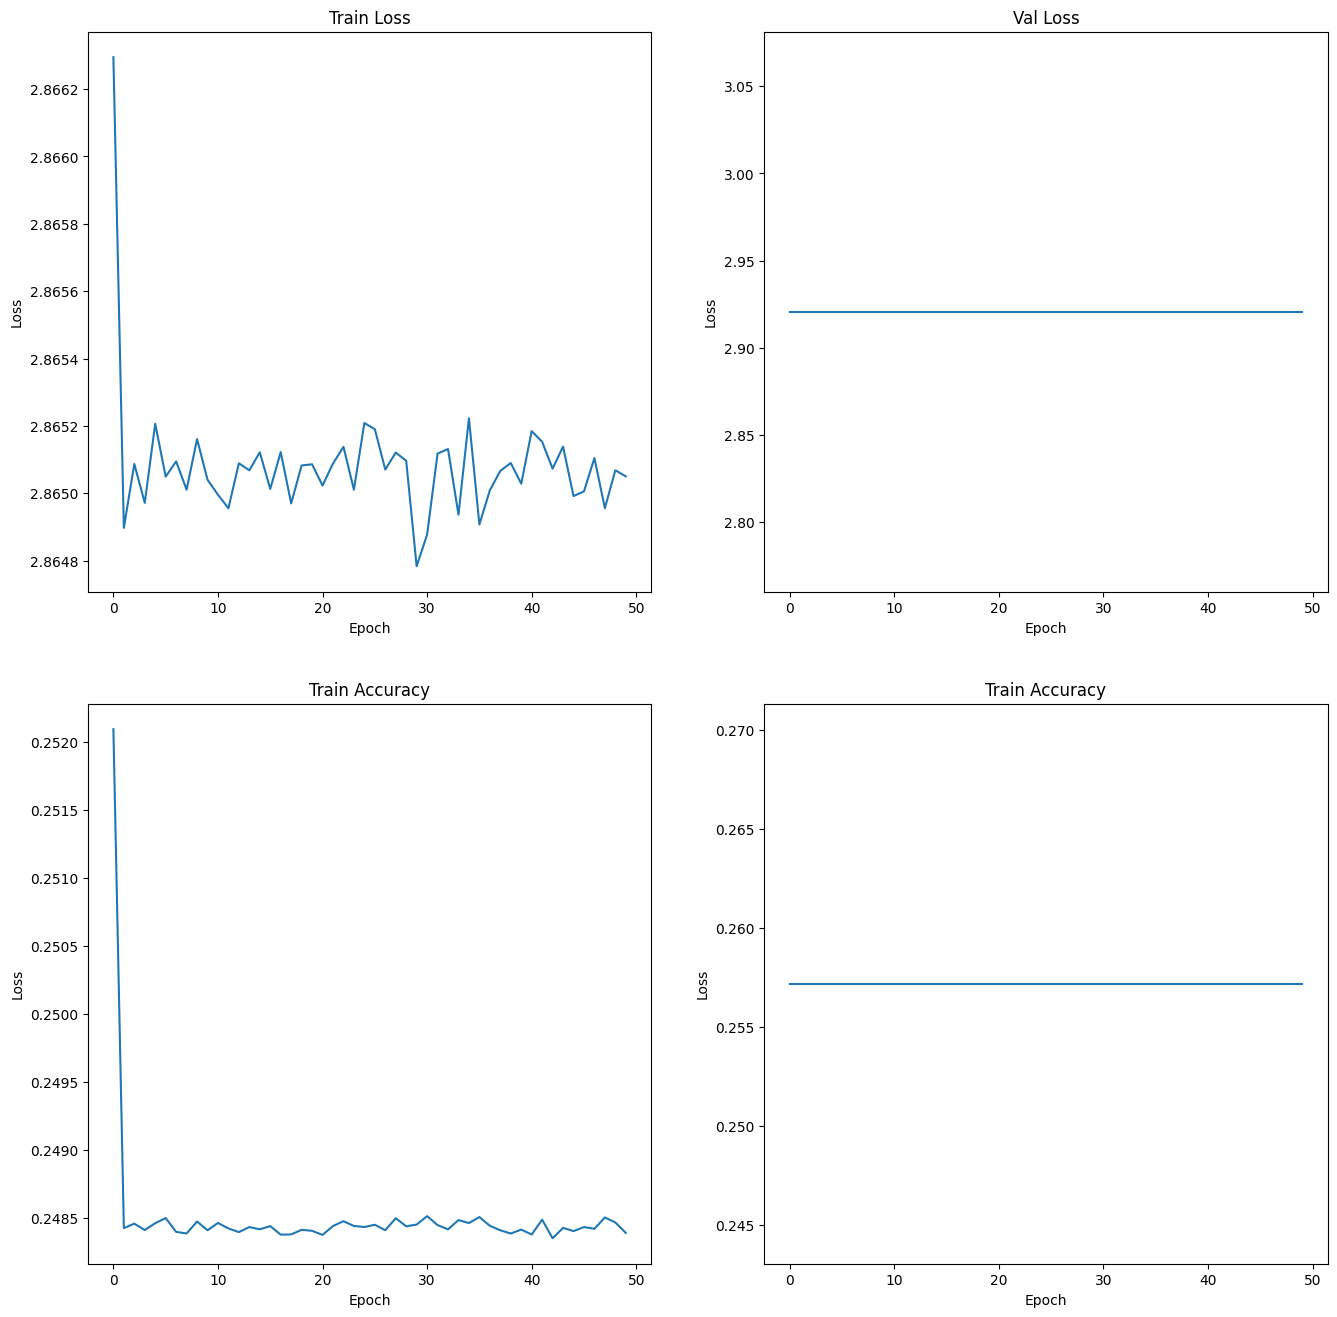

In [34]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Loss")

plt.subplot(2, 2, 2)
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Val Loss")

plt.subplot(2, 2, 3)
plt.plot(train_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Accuracy")

plt.subplot(2, 2, 4)
plt.plot(val_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Train Accuracy")

In [35]:
def get_mask(model, image):
    """
        model: UNet model
        image: input image, size of (B, C, W, H)
    """
    # Compute logit
    model.eval()
    mask_logit = model(image)
    mask_logit = F.interpolate(mask_logit, size=(1024, 2048), mode='bilinear', align_corners=False)
    print(mask_logit.shape)
    mask_logit = mask_logit.permute(0, 2, 3, 1)
    mask_pred = torch.argmax(mask_logit, dim = -1) # Get label
    print(mask_pred.shape)
    mask_pred = mask_pred.squeeze() # Remove batch
    mask_pred = mask_pred.cpu().numpy()
    print(mask_pred.shape)
    
    # Color mapping
    rgb_mask = np.zeros((1024, 2048, 3), dtype=np.uint8)
    for class_id in range(color_map.shape[0]):
        rgb_mask[mask_pred == class_id] = color_map[class_id]

    return rgb_mask

In [36]:
def show_img(path):
    image = Image.open(path).convert('RGB')
    original_size = image.size
    
    print(original_size)
    plt.imshow(image)

(2048, 1024)


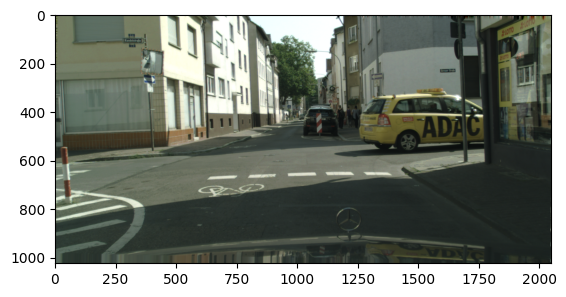

In [37]:
img_path = '/kaggle/input/cityscapes/Cityspaces/images/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png'

show_img(img_path)

(2048, 1024)


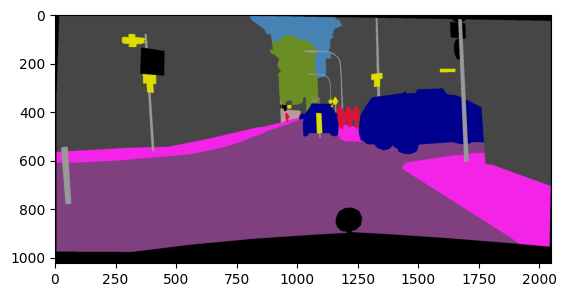

In [38]:
gt = '/kaggle/input/cityscapes/Cityspaces/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'
show_img(gt)

In [39]:
img = val_subset[0]

In [40]:
img[0].shape

torch.Size([3, 512, 1024])

In [41]:
in_img = torch.Tensor(img[0].unsqueeze(0))

In [42]:
in_img.shape

torch.Size([1, 3, 512, 1024])

In [43]:
img[1].view(-1).shape

torch.Size([2097152])

In [44]:
mask_logits = unet(in_img)
print(mask_logits.shape)
mask_logits = F.interpolate(mask_logits, size=(1024, 2048), mode='bilinear', align_corners=False)
print(mask_logits.shape)
mask_logits = mask_logits.permute(0,2,3,1)
print(mask_logits.shape)
print(mask_logits.reshape(-1, 19).shape)

mask_pred = torch.argmax(mask_logits, dim = -1)

torch.Size([1, 19, 512, 1024])
torch.Size([1, 19, 1024, 2048])
torch.Size([1, 1024, 2048, 19])
torch.Size([2097152, 19])


In [45]:
mask_pred.shape

torch.Size([1, 1024, 2048])

In [46]:
pred = get_mask(unet, in_img)

torch.Size([1, 19, 1024, 2048])
torch.Size([1, 1024, 2048])
(1024, 2048)


In [47]:
pred_img = Image.fromarray(pred)

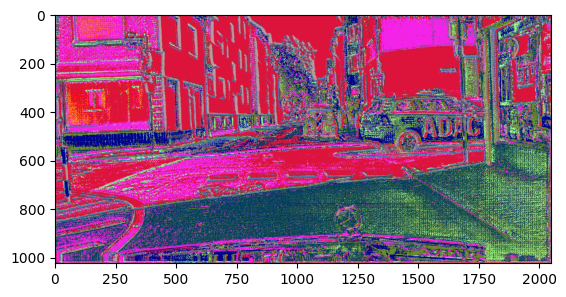

In [48]:
plt.imshow(pred_img)